In [11]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plotBarcodes, plotConfidenceEllipse, labelAxes
from utils.fim_utils import computeFimFunctional, logTransform
from mapk_model import YeastModel
rc('text', usetex=True)
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

# Create folders to store outputs if they do not exist
import pathlib as pl
for folder_name in ["tables", "figs"]:
    path_to_folder = pl.Path(f"./{folder_name}")
    if not path_to_folder.exists():
        path_to_folder.mkdir()

In [12]:

model = YeastModel()
theta = np.array([model.k_01,
                  model.k_10a,
                  model.k_10b,
                  model.k_12,
                  model.k_21,
                  model.k_23,
                  model.k_32,
                  model.alpha_0,
                  model.alpha_1,
                  model.alpha_2,
                  model.alpha_3,
                  model.k_trans,
                  model.gamma_nuc,
                  model.gamma_cyt])
fims = {}
with np.load('results/fim_exact.npz') as _:
    fims['full'] = _["fim"]
with np.load('results/fim_marginals.npz') as _:
    fims['nuc'] = _['nuc_only']
    fims['cyt'] = _['cyt_only']
with np.load('results/fim_total_rna.npz') as _:
    fims['total'] = _['fim']
with np.load('results/fim_joint_rna.npz') as _:
    fims['joint'] = _['fim']
for key in fims.keys():
    logTransform(fims[key], theta)

parameter_labels=[
    r"k_{01}",
    r"k_{10}^{(a)}",
    r"k_{10}^{(b)}",
    r"k_{12}",
    r"k_{21}",
    r"k_{23}",
    r"k_{32}",
    r"\alpha_0",
    r"\alpha_1",
    r"\alpha_2",
    r"\alpha_3",
    r"k_{trans}",
    r"\gamma_{nuc}",
    r"\gamma_{cyt}",
]
measurement_types = ['full', 'joint', 'nuc', 'cyt', 'total' ]

## Compare joint vs. single-species measurements and half-and-half combination of measurement types



In [13]:
def find_multiple_time_fim(dt: int, fims: np.ndarray)->np.ndarray:
    """
    Compute the FIM associated with an experiment that collect cells over 2 equi-spaced time points from the FIMs associated with
    single time points.
    """
    idxs = [k*dt for k in range(1, 6)]
    return np.sum(fims[idxs], axis=0)

In [14]:
fim_mt_single_obs = {}
n_cells = 1000
max_dt = 12
for observation_type in measurement_types:
    fim_mt_single_obs[observation_type] = []
    for dt in range(0, max_dt+1):
        fim_mt_single_obs[observation_type].append(
            find_multiple_time_fim(dt, n_cells*fims[observation_type])
        )
    fim_mt_single_obs[observation_type] = np.array(fim_mt_single_obs[observation_type])

In [15]:
# D-optimality for single observation

In [16]:
detf = {}
dt_opt = {}
for observation_type in measurement_types:
    detf[observation_type] = computeFimFunctional(fim_mt_single_obs[observation_type])
    dt_opt[observation_type] = np.argmax(detf[observation_type])

/var/folders/3m/mfkcqvp50y14vj21n2tcg4h80000gn/T/ipykernel_3460/1543696545.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figs/mapk_experiments.png", dpi=300, bbox_inches="tight")
/Users/huyvo/miniforge3/envs/fimhuyvo2022/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


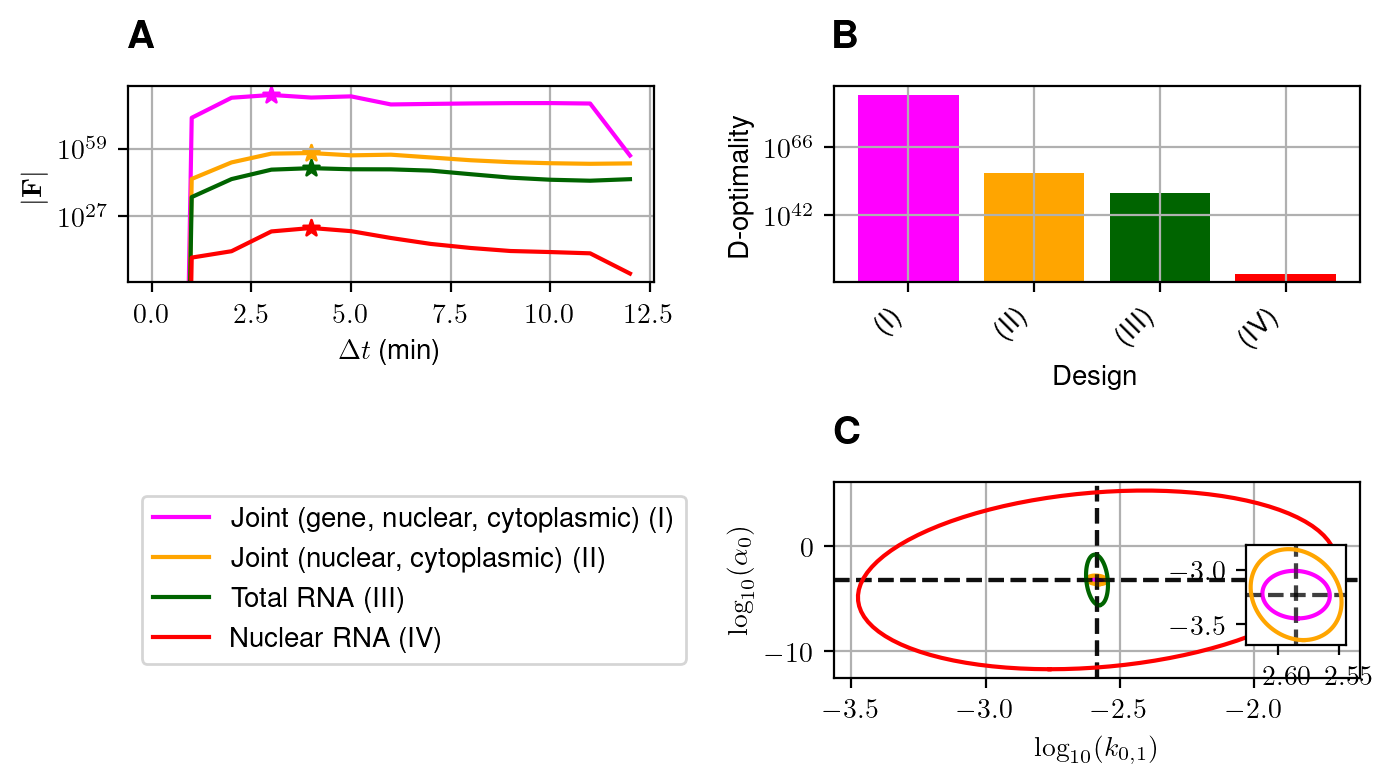

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

fig = plt.figure(figsize=(7, 4), dpi=200, tight_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1])
]

for ax in axs:
    ax.grid(True)

schemes = ['full', 'joint', 'total',  'nuc']
labels = {'full': r"Joint (gene, nuclear, cytoplasmic) (I)",
          'nuc': "Nuclear RNA (IV)",
          'cyt': "Cytoplasmic RNA (V)",
          'total': "Total RNA (III)",
          'joint': "Joint (nuclear, cytoplasmic) (II)"}
colors = {'full': "magenta",
          'nuc': "red",
          'cyt': "green",
          'total': "darkgreen",
          'joint': "orange"}

# Compare D-optimality across sampling periods
for observation_type in schemes:
    label = labels[observation_type]
    color = colors[observation_type]
    axs[0].plot(detf[observation_type], label=label, color=color)
    dt = dt_opt[observation_type]
    axs[0].scatter(dt, detf[observation_type][dt], marker="*", color=color)

axs[0].set_yscale("log")
axs[0].set_ylabel(r"$|\mathbf{F}|$")
axs[0].set_xlabel(r"$\Delta{t}$ (min)")

# Bar charts for the optimal design for each measurement method
for i, design in enumerate(schemes):
    d_value = detf[design][dt_opt[design]]
    axs[1].bar(i, d_value, color=colors[design])

axs[1].set_yscale("log")
axs[1].set_xticks([0, 1, 2, 3])
bar_labels = ['(I)', '(II)', '(III)', '(IV)']
# bar_labels = [labels[design] for design in schemes]
axs[1].set_xticklabels(bar_labels, rotation=45, ha='right')
axs[1].set_xlabel("Design")
axs[1].set_ylabel("D-optimality")

# Compare confidence ellipses
for observation_type in schemes:
    color = colors[observation_type]
    plotConfidenceEllipse(fim=fim_mt_single_obs[observation_type][dt], num_sigma=3,
                  ax=axs[2], par_idx=[0, 7], theta=np.log10(theta), label=label, color=color
                  )
inaxs2 = inset_axes(axs[2], width=0.5, height=0.5, loc=4, bbox_to_anchor=(0.1, 0.1, 0.9, 0.9),
                    bbox_transform=axs[2].transAxes)
for observation_type in ['full', 'joint']:
    color = colors[observation_type]
    plotConfidenceEllipse(fim=fim_mt_single_obs[observation_type][dt], num_sigma=3,
                  ax=inaxs2, par_idx=[0, 7], theta=np.log10(theta), label=label, color=color
                  )
axs[2].set_xlabel(r"$\log_{10}(k_{0,1})$")
axs[2].set_ylabel(r"$\log_{10}(\alpha_0)$")
labelAxes(axs)


h, l = axs[0].get_legend_handles_labels()
legendax = fig.add_subplot(gs[1,0])
legendax.axis("off")
legendax.legend(h, l, loc="upper left", ncol=1, bbox_to_anchor=(0, 0, 1, 1))
fig.savefig("figs/mapk_experiments.png", dpi=300, bbox_inches="tight")

## Joint measurement at optimal sampling period vs mixed measurements under optimal sampling period and mixture

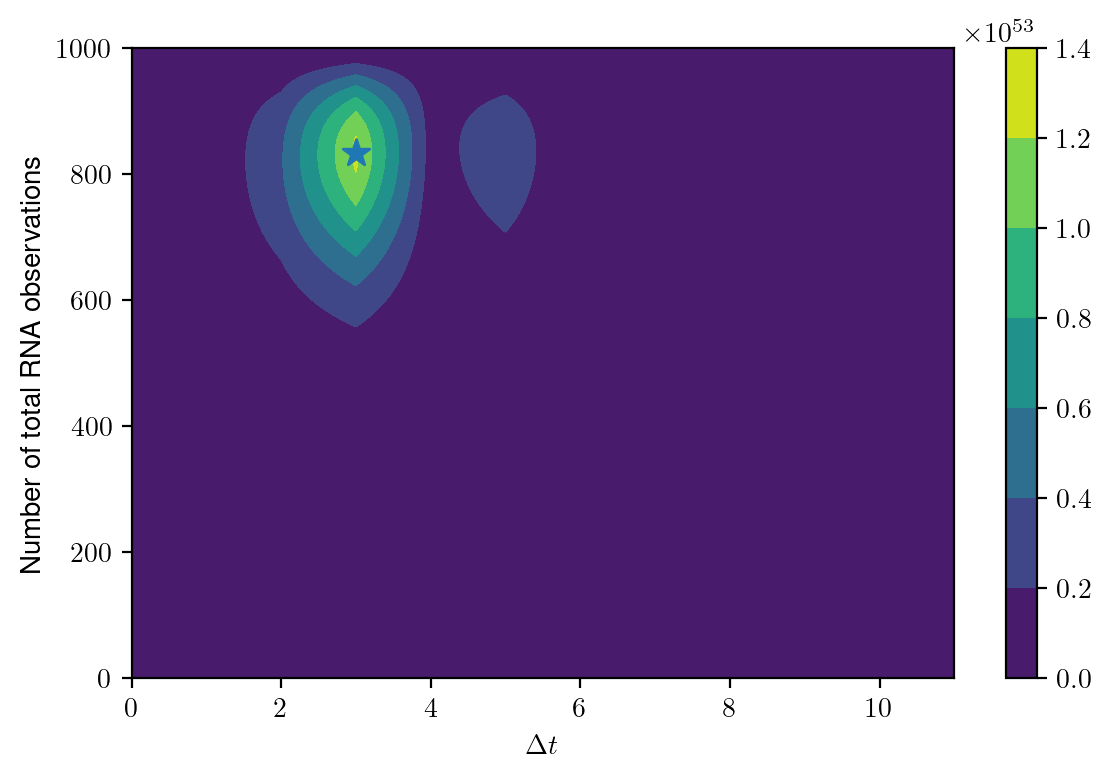

In [18]:
with np.load('results/combined_fim_dopt.npz', allow_pickle=True) as _:
    fim_opt_dt_mixture = _['fim_opt']
    nx_opt_mixture = _['nx_opt']
    dt_opt_mixture = _['dt_opt']
    fim_mixture_dets = _['fim_dets']

fig = plt.figure(dpi=200, tight_layout=True)
ax = fig.subplots(1,1)
h = ax.contourf(fim_mixture_dets)
fig.colorbar(h)
ax.set_xlabel(r'$\Delta{t}$')
ax.set_ylabel(r'Number of total RNA observations')
ax.scatter(dt_opt_mixture, nx_opt_mixture, marker='*', s=100)
fig.savefig('figs/mapk_fim_mixture_dopt.png', dpi=400, bbox_inches="tight")

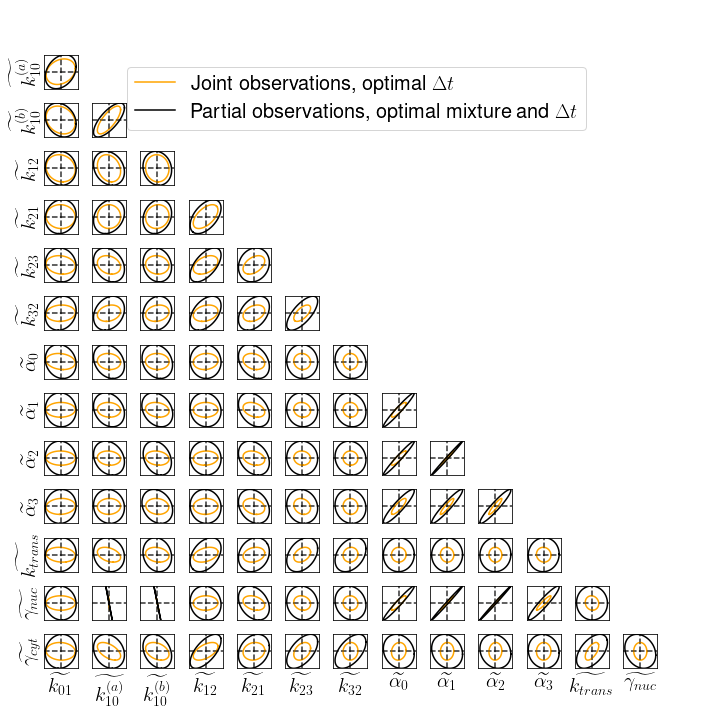

In [19]:
num_pars = model.NUM_PARAMETERS
fig = plt.figure(figsize=(10, 10), tight_layout=True)
axs = fig.subplots(num_pars, num_pars, sharex='col', sharey='row')
for i in range(num_pars):
    for j in range(i, num_pars):
        axs[i, j].axis("off")
    for j in range(0, i):
        plotConfidenceEllipse(fim=fim_mt_single_obs['joint'][dt_opt['joint']],
                          num_sigma=3,
                  ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="orange", label=r"Joint observations, optimal $\Delta{t}$", )
        plotConfidenceEllipse(fim=fim_opt_dt_mixture, num_sigma=3,
                   ax=axs[i, j], par_idx=[j, i], theta=np.log10(theta),
                  color="k", label=r"Partial observations, optimal mixture and $\Delta{t}$")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].autoscale(True, tight=True)


for i in range(num_pars):
    axs[i, 0].set_ylabel(rf"$\widetilde{{{parameter_labels[i]}}}$", fontsize=20)
    axs[-1, i].set_xlabel(rf"$\widetilde{{{parameter_labels[i]}}}$", fontsize=20)

h, l = axs[1, 0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0.5, 0.8, 0, 0.5), fontsize=20)
fig.savefig("figs/mapk_conf_ellipse_opt_mixture.png", dpi=500, bbox_inches="tight")

In [20]:
import pandas as pd

lst = []
for design in measurement_types:
    lst.append(
        [
            labels[design],
            dt_opt[design],
            detf[design][dt_opt[design]]
        ]
    )
lst.append([
    f'{nx_opt_mixture} total RNA, {1000-nx_opt_mixture} nuclear RNA (optimal)',
    dt_opt_mixture,
    fim_mixture_dets[nx_opt_mixture, dt_opt_mixture]
])
df = pd.DataFrame(lst, columns=['Design', 'Optimal sampling period (minute)', 'D-optimality information'])
print(df)
df.to_csv('tables/yeast_designs.csv',
          sep=";",
          float_format="%.2e", index=False)

                                     Design Optimal sampling period (minute)  \
0    Joint (gene, nuclear, cytoplasmic) (I)                                3   
1         Joint (nuclear, cytoplasmic) (II)                                4   
2                          Nuclear RNA (IV)                                4   
3                       Cytoplasmic RNA (V)                                4   
4                           Total RNA (III)                                4   
5  833 total RNA, 167 nuclear RNA (optimal)                                3   

   D-optimality information  
0              2.844669e+84  
1              7.023393e+56  
2              1.815976e+21  
3              4.471633e+49  
4              4.721843e+49  
5              1.238044e+53  
